In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.special import erfinv

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cmr
%matplotlib inline

import time

eps = 2*np.sqrt(np.finfo("float").eps)

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
def integral(y, x):
    return simpson(y, x, axis = 0)

In [4]:
def random_mat_cor(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    D = np.diagonal(B)[np.newaxis]
    
    mat_cor = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_cor

In [5]:
def random_mat_dom(P):
    
    A = np.random.normal(size = (P, P))
    B = A @ A.T
    
    B = np.abs(B)
    np.fill_diagonal(B, np.sum(B, axis = 0))
    
    D = np.diagonal(B)[np.newaxis]
    
    mat_dom = D.T**(-1/2) * B * D**(-1/2)
    
    return mat_dom

In [6]:
def simple_mat_cor(P, c):
    mat_cor = (1 - c) * np.eye(P, P) + c * np.ones((P, P))
    
    return mat_cor

In [7]:
def random_multivariate_binary(mat_cor, P, n_binary_samples):
    spins_x = np.sign(np.random.multivariate_normal(np.zeros(P), np.sin(np.pi/2 * mat_cor), n_binary_samples))
    
    return spins_x

In [27]:
class Iterator():
    def __init__(self, beta_s, beta, alpha, mat_cor, P_s, P, n_normal_samples, n_binary_samples):
        self.mat_cor = mat_cor
        self.P_s = P_s
        self.P = P
        
        spins_s_base = np.full((P_s, 2), np.array([-1, 1]))
        
        spins_base = np.full((P, 2), np.array([-1, 1]))
        
        self.spins_s = np.array(np.meshgrid(*spins_s_base)).T.reshape(-1, 1, P_s, 1)
        self.spins_s_T = np.transpose(self.spins_s, axes = (0, 1, 3, 2))
        
        self.spins = np.array(np.meshgrid(*spins_base)).T.reshape(-1, 1, 1, P, 1)
        self.spins_T = np.transpose(self.spins, axes = (0, 1, 2, 4, 3))
        
        # self.spins_v = self.spins.reshape(-1, 1, P, 1)
        # self.spins_v_T = self.spins_s_T.reshape(-1, 1, 1, P)
        
        # self.spins_u = self.spins_s.reshape(-1, 1, 1, 1, P, 1)
        # self.spins_u_T = self.spins_s_T.reshape(-1, 1, 1, 1, 1, P)
        
        z_off_diag = np.random.normal(size = (n_normal_samples, P*(P - 1)//2))
        z_off_diag = (z_off_diag - np.flip(z_off_diag, axis = 0))/2
        
        C = np.array(np.cov(z_off_diag, rowvar = False), ndmin = 2)
        L = np.linalg.cholesky(C)
        z_off_diag = np.linalg.solve(L, z_off_diag.T).T
        
        self.z_off_diag = np.zeros((n_normal_samples, P, P))
        
        self.z_off_diag[:, np.tri(P, dtype = "bool", k = -1)] = z_off_diag
        
        self.z_off_diag = self.z_off_diag + np.transpose(self.z_off_diag, axes = (0, 2, 1))
        
        z_on_diag = np.random.normal(size = (n_normal_samples, P))
        z_on_diag = (z_on_diag - np.flip(z_on_diag, axis = 0))/2
        
        C = np.array(np.cov(z_on_diag, rowvar = False), ndmin = 2)
        L = np.linalg.cholesky(C)
        z_on_diag = np.linalg.solve(L, z_on_diag.T).T
        
        self.z_on_diag = z_on_diag[:, np.newaxis]
        
        spins_x = random_multivariate_binary(mat_cor, P_s, n_binary_samples).reshape(1, -1, P_s, 1)
        
        self.p_x = np.mean(np.all(self.spins_s == spins_x, axis = 2, keepdims = True), axis = 1, keepdims = True)
        
        self.update_params(beta_s, beta, alpha)
    
    def update_params(self, beta_s, beta, alpha):
        self.beta_s = beta_s
        self.beta = beta
        self.alpha = alpha
        H_M_s = self.hamiltonian(self.beta, self.mat_cor, spins_s = True)
        self.p_M_s = self.probability(H_M_s)
    
    def action_eff(self, m, s, q_on_diag, q_off_diag, beta_s, beta):
        
        q_sub = q_on_diag - np.sum(q_off_diag, axis = 1, keepdims = True)
        
        H_L = beta * (self.spins_T * self.z_on_diag) @ np.sqrt(q_sub + 0j)
        
        H_L = H_L + beta * (self.spins_T @ np.sum(self.z_off_diag * np.sqrt(q_off_diag + 0j), axis = -1, keepdims = True))
        
        H_L = H_L + 1/2*beta**2 * (self.spins_T @ (s - q_off_diag) @ self.spins) + beta_s*beta * (self.spins_s_T @ m @ self.spins)
        
        return H_L
    
    def hamiltonian(self, beta, mat_cor, spins_s):
        if spins_s == True:
            return 1/2*beta**2 * (self.spins_s_T @ mat_cor @ self.spins_s)
        else:
            return 1/2*beta**2 * (self.spins_T @ mat_cor @ self.spins)
    
    def probability(self, H):
        C = np.max(H, axis = 0)
        M = np.exp(H - C)
        return M / np.sum(M, axis = 0)
    
    def update(self, m, s, q, print_comparison = False):
        
        q_on_diag = np.diagonal(q).copy()[:, np.newaxis]
        q_off_diag = q - np.eye(P, P) * q_on_diag
        
        H_L = self.action_eff(m, s, q_on_diag, q_off_diag, self.beta_s, self.beta)
        p_L = np.real(self.probability(H_L))
        
        H_M = self.hamiltonian(self.beta, s, spins_s = False)
        p_M = self.probability(H_M)
        
        m_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M_s * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M_s * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - np.sum(p_M * self.spins_T * self.spins, axis = 0))
        q_hat = self.beta**2*self.alpha * np.squeeze(np.sum(self.p_M_s * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        # q_num = np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True)
        # q_ana_on_diag = np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag)**2, axis = 0, keepdims = True)
        # q_ana_off_diag = np.mean(np.tanh(self.beta**2 + self.beta * self.z_on_diag), axis = 0, keepdims = True)**2
        
        # q_ana = q_ana_on_diag * np.eye(P, P) + q_ana_off_diag * (np.ones((P, P)) - np.eye(P, P))
        # q_ana = self.spins_s_T * self.spins_s * q_ana
        
        # q_max = np.max(q)
        
        # print("Intermediate numerical result:")
        # print(q_num)
        # print("Intermediate analytical result:")
        # print(q_ana)
        
        # print("Final numerical result:")
        # print(np.sum(self.p_M * q_num, axis = 0))
        # print("Final analytical result:")
        # print(np.sum(self.p_M * q_ana, axis = 0))
        
        if print_comparison:
        
            print("Numerical m_hat:")
            print(m_hat)
            print("Numerical s_hat:")
            print(s_hat)
            print("Numerical q_hat:")
            print(q_hat)
            
            m_max = np.max(m)
            m_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 * m_max + self.beta * self.z_on_diag * np.sqrt(m_max)))
            
            q_max = np.max(q)
            q_test = self.beta**2 * self.alpha * np.mean(np.tanh(self.beta**2 * q_max + self.beta * self.z_on_diag * np.sqrt(q_max))**2)
            
            print("Analytical m_hat:")
            print(m_test)
            print("Analytical q_hat:")
            print(q_test)
            
        q_hat_on_diag = np.diagonal(q_hat).copy()[:, np.newaxis]
        q_hat_off_diag = q_hat - np.eye(P, P) * q_hat_on_diag
        
        H_L = self.action_eff(m_hat, s_hat, q_hat_on_diag, q_hat_off_diag, 1, 1)
        p_L = np.real(self.probability(H_L))
        
        m = np.squeeze(np.sum(self.p_x * np.mean(self.spins_s * np.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        q = np.squeeze(np.sum(self.p_x * np.mean(np.sum(p_L * self.spins_T, axis = 0) * np.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        if print_comparison:
            
            print("Numerical m:")
            print(m)
            print("Numerical s:")
            print(s)
            print("Numerical q:")
            print(q)
            
            m_max = np.max(m_hat)
            m_test = np.mean(np.tanh(m_max + self.z_on_diag * np.sqrt(m_max)))
            
            q_max = np.max(q_hat)
            q_test = np.mean(np.tanh(q_max + self.z_on_diag * np.sqrt(q_max))**2)
            
            print("Analytical m:")
            print(m_test)
            print("Analytical q:")
            print(q_test)
        
        return m, s, q
    
    def iterate(self, m, s, q, t, store_state, print_comparison = False):
        
        q = (q + q.T)/2
        
        m_list = []
        s_list = []
        q_list = []
        
        start = time.time()
        
        for _ in range(t):
            if store_state:
                m_list.append(m)
                s_list.append(s)
                q_list.append(q)
            
            m, s, q = self.update(m, s, q, print_comparison)
        
        m_list.append(m)
        s_list.append(s)
        q_list.append(q)
        
        end = time.time()
        print("Timing:")
        print(end - start)
        
        return m_list, s_list, q_list

In [77]:
class Simple_iterator():
    def __init__(self, beta, alpha, n_samples, n_stds = 5):
        self.z = np.linspace(-n_stds, n_stds, num = n_samples, endpoint = True)
        
        self.update_params(beta, alpha)
    
    def update_params(self, beta, alpha):
        self.beta = beta
        self.alpha = alpha
    
    def update(self, m):
        m_hat = beta**2*alpha * integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2)
                                         * np.tanh(beta**2 * m + beta * np.sqrt(m) * self.z), self.z)
    
        m = integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2) * np.tanh(m_hat + np.sqrt(m_hat) * self.z), self.z)
        
        return m
    
    def iterate(self, m, t, store_state):
        
        m_list = []
        
        for _ in range(t):
            if store_state:
                m_list.append(m)
            
            m = self.update(m)
        
        m_list.append(m)
        
        return m_list

In [39]:
n_normal_samples = 200000
n_binary_samples = 2000000

beta_s = 1.2
beta = 1.2
alpha = 1.4
P_s = 2
P = 3
c = 0

mat_cor = simple_mat_cor(P_s, c)

iterator = Iterator(beta_s, beta, alpha, mat_cor, P_s, P, n_normal_samples, n_binary_samples)

Numerical m_hat:
[[1.34537212e+00 1.67865721e-16 4.23763025e-18]
 [2.23820962e-16 1.34617217e+00 2.82168289e-18]]
Numerical s_hat:
[[0.00000000e+00 5.77736928e-05 1.18970036e-04]
 [5.77736928e-05 0.00000000e+00 3.09727832e-04]
 [1.18970036e-04 3.09727832e-04 0.00000000e+00]]
Numerical q_hat:
[[1.34566146e+00 5.77736928e-05 1.18970036e-04]
 [5.77736928e-05 1.34642321e+00 3.09727832e-04]
 [1.18970036e-04 3.09727832e-04 9.27051495e-01]]
Analytical m_hat:
1.3458486612185343
Analytical q_hat:
1.3461536246238506
Numerical m:
[[6.45540585e-01 2.77805401e-05 6.18927611e-18]
 [2.77582452e-05 6.46059073e-01 7.47168965e-18]]
Numerical s:
[[1.00000000e+00 5.07376669e-05 7.38894719e-05]
 [5.07376669e-05 1.00000000e+00 2.38138355e-04]
 [7.38894719e-05 2.38138355e-04 1.00000000e+00]]
Numerical q:
[[6.45673936e-01 5.07376669e-05 7.38894719e-05]
 [5.07376669e-05 6.46200215e-01 2.38138355e-04]
 [7.38894719e-05 2.38138355e-04 3.79771518e-01]]
Analytical m:
0.6459871750247523
Analytical q:
0.6461553907231

Numerical m_hat:
[[ 9.44491998e-01 -3.04726508e-05 -2.66502753e-03]
 [-3.08958582e-05  9.46011933e-01 -7.49432667e-03]]
Numerical s_hat:
[[ 2.23820962e-16  5.69652638e-05 -3.12607417e-04]
 [ 5.69652638e-05  2.23820962e-16 -9.98757142e-04]
 [-3.12607417e-04 -9.98757142e-04  2.23820962e-16]]
Numerical q_hat:
[[ 9.45189973e-01 -1.83839739e-06 -1.20417124e-03]
 [-1.83839739e-06  9.47148194e-01 -3.54240234e-03]
 [-1.20417124e-03 -3.54240234e-03  4.67054067e-01]]
Analytical m_hat:
0.9460304419247544
Analytical q_hat:
0.9463532463388887
Numerical m:
[[ 5.32364638e-01  2.14034303e-05 -1.61605883e-03]
 [ 2.12217352e-05  5.33178593e-01 -4.52839694e-03]]
Numerical s:
[[ 1.00000000e+00  6.11076514e-05 -6.27193762e-04]
 [ 6.11076514e-05  1.00000000e+00 -1.83830652e-03]
 [-6.27193762e-04 -1.83830652e-03  1.00000000e+00]]
Numerical q:
[[ 5.32933220e-01  4.95821146e-05 -5.16346872e-04]
 [ 4.95821146e-05  5.34375014e-01 -1.48848565e-03]
 [-5.16346872e-04 -1.48848565e-03  2.65146166e-01]]
Analytical m:


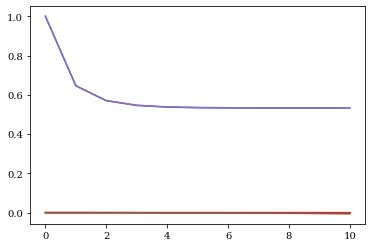

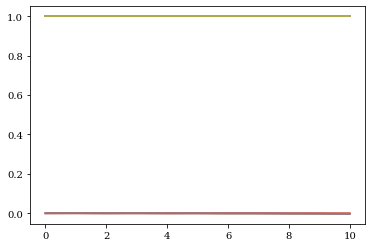

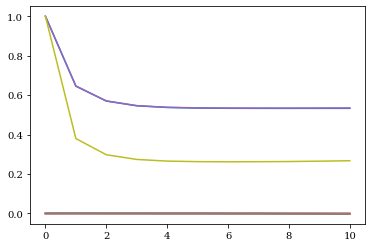

In [40]:
# Probe c = 0.1, 0.4, 0.7, 1
# or c = 0.1, 0.25, 0.4, 0.55, 0.7, 0.85, 1

t = 10

m = np.eye(P_s, P) # random_mat_cor(P)
s = np.eye(P) # random_mat_cor(P)
q = np.eye(P) # random_mat_cor(P)

m_list, s_list, q_list = iterator.iterate(m, s, q, t, store_state = True, print_comparison = True)

plt.plot(np.array(m_list).reshape(t+1, P_s*P))
plt.show()

plt.plot(np.array(s_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(q_list).reshape(t+1, P**2))
plt.show()

In [ ]:
5.3245
5.3
5.33
5.33

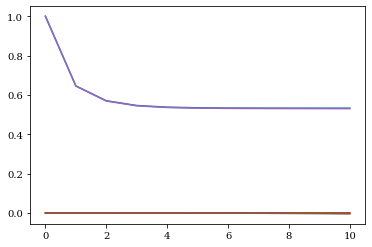

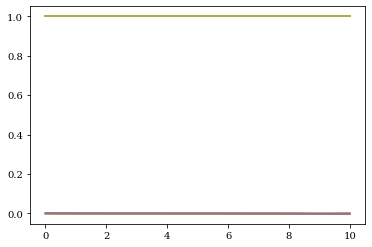

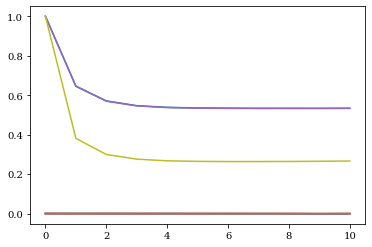

In [32]:
plt.plot(np.array(m_list).reshape(t+1, P_s*P))
plt.show()

plt.plot(np.array(s_list).reshape(t+1, P**2))
plt.show()

plt.plot(np.array(q_list).reshape(t+1, P**2))
plt.show()

In [ ]:
Naive
Analytical m:
0.5321204789416168
Analytical q:
0.5324654995077027
Timing:
89.636301279068

Refined
Analytical m:
0.532812835596838
Analytical q:
0.5327209555821752
Timing:
108.46871209144592

Naive
Analytical m:
0.5338574698216193
Analytical q:
0.533778807954293
Timing:
369.9784746170044

Refined
Analytical m:
0.5320265450824956
Analytical q:
0.5326315941891661
Timing:
520.0692989826202

In [ ]:
n_normal_samples = 200000
n_binary_samples = 2000000
n_simple_samples = 401
t = 10

n_alpha = 20

q_comp_range = np.zeros(n_alpha)
q_simp_range = np.zeros(n_alpha)

beta_s = 1.2
beta = 1.2
alpha = 0
P_s = 4
P = 4
c = 0

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta_s, beta, alpha, mat_cor, P_s, P, n_normal_samples, n_binary_samples)

simple_iterator = Simple_iterator(beta, alpha, n_simple_samples)

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_init = np.eye(P_s, P) # random_mat_cor(P)
s_init = np.eye(P) # random_mat_cor(P)
q_init = np.eye(P) # random_mat_cor(P)

for j, alpha in enumerate(alpha_range):
    iterator.update_params(beta_s, beta, alpha)
    m, s, q = iterator.iterate(m_init, s_init, q_init, t, store_state = False)
    q_comp_range[j] = np.max(m)
    
    m = simple_iterator.iterate(1, t, store_state = False)
    
    q_simp_range[j] = np.squeeze(m)

fontsize = 13

figure, (axis1, axis2) = plt.subplots(nrows = 2, ncols = 1, sharex = True)

axis1.plot(alpha_range, q_simp_range, linestyle = "-")
axis1.plot(alpha_range, q_comp_range, linestyle = "--", linewidth = 3)
axis1.tick_params(axis = "both", which = "major", labelsize = fontsize)
axis1.tick_params(axis = "both", which = "minor", labelsize = fontsize)
axis1.set_ylabel(r"Magnetization $m$", fontsize = fontsize)
axis1.legend([r"$1$ hidden unit", r"$%d$ hidden units" % P], fontsize = fontsize)


axis2.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-")
axis2.plot(alpha_range, q_comp_range - q_simp_range, linestyle = "--", linewidth = 3)
axis2.tick_params(axis = "both", which = "major", labelsize = fontsize)
axis2.tick_params(axis = "both", which = "minor", labelsize = fontsize)
axis2.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
axis2.set_ylabel(r"Residuals", fontsize = fontsize)

plt.show()

with open("./Data/BM_uncorrelated_overlap_P=%d_beta=%.2f_.npy" % (P, beta), "wb") as file:
    np.save(file, q_range)

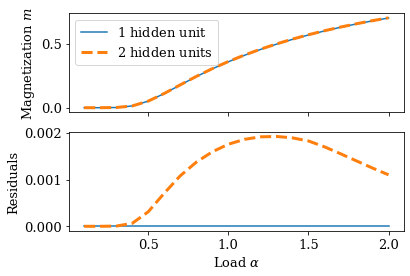

In [21]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.015, 1.3, num = n_beta, endpoint = True)
print(T_range)

alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)
print(alpha_range)

[1.015 1.03  1.045 1.06  1.075 1.09  1.105 1.12  1.135 1.15  1.165 1.18
 1.195 1.21  1.225 1.24  1.255 1.27  1.285 1.3  ]
[0.67 0.74 0.81 0.88 0.95 1.02 1.09 1.16 1.23 1.3  1.37 1.44 1.51 1.58
 1.65 1.72 1.79 1.86 1.93 2.  ]


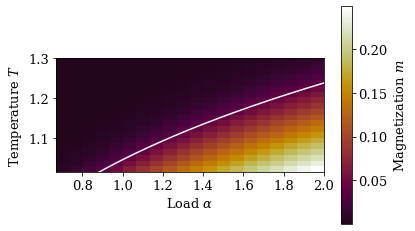

In [23]:
n_normal_samples = 200000
n_binary_samples = 2000000
t = 10

n_beta = 20
n_alpha = 20

q_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

beta_s = 0
beta = 0
alpha = 0
P_s = 2
P = 2
c = 0.1

mat_cor = simple_mat_cor(P, c)

iterator = Iterator(beta_s, beta, alpha, mat_cor, P_s, P, n_normal_samples, n_binary_samples)

# T_range = np.linspace(1.0225, 1.45, num = n_beta, endpoint = True)
# alpha_range = np.linspace(0.385, 2, num = n_alpha, endpoint = True)

T_range = np.linspace(1.015, 1.3, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

m_init = np.eye(P_s, P) # random_mat_cor(P)
s_init = np.eye(P) # random_mat_cor(P)
q_init = np.eye(P) # random_mat_cor(P)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        iterator.update_params(1/T, 1/T, alpha)
        m, s, q = iterator.iterate(m_init, s_init, q_init, t, store_state = False)
        q_range[i, j] = np.mean(m)
    
    d = np.squeeze(np.sum(iterator.p_M * iterator.spins_s_T * iterator.spins_s, axis = 0))[0, 1]
    eigval = (P - 1)**2 * c*d + (P - 1) * (c + d) + 1
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(q_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

with open("./Data/BM_phase_diagram_c=%.2f.npy" % c, "wb") as file:
    np.save(file, q_range)

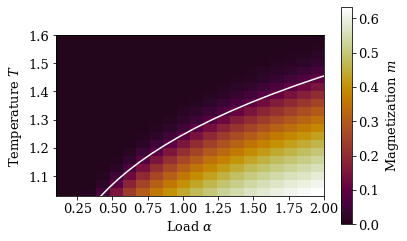

In [776]:
c = 0.7

with open("./Data/BM_phase_diagram_c=%.2f.npy" % c, "rb") as file:
    q_range = np.load(file)

fontsize = 13

plt.imshow(q_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)))
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

# $S = \beta^4 \alpha Q R$
# $\alpha_{\text{crit}} \leq \frac{1}{\beta^4 \lambda^S_{\text{max}}}$

### Plot unrelated probability distributions

In [12]:
def prob(x, p):
    return np.exp(-x**p)

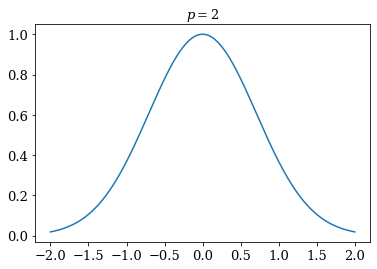

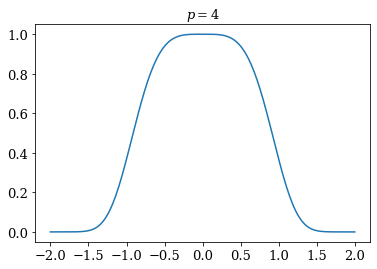

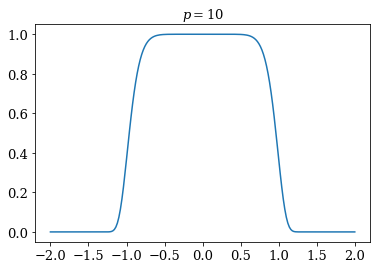

In [24]:
fontsize = 13

x = np.linspace(-2, 2, num = 201, endpoint = True)
p_range = np.array([2, 4, 10])

for p in p_range:
    plt.plot(x, prob(x, p))
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title(r"$p = %d$" % p, fontsize = fontsize)
    plt.show()